In [1]:
# import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

#For Data  Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For Machine Learning Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel('train.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,558904,22292,HANGING CHICK YELLOW DECORATION,1,2011-07-04 16:18:00,1.25,NaN,United Kingdom
1,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,16126.0,United Kingdom
2,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,18118.0,United Kingdom
3,541658,21988,PACK OF 6 SKULL PAPER PLATES,1,2011-01-20 12:16:00,0.85,15529.0,United Kingdom
4,538364,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-10 17:26:00,1.95,14448.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379336 entries, 0 to 379335
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    379336 non-null  object        
 1   StockCode    379336 non-null  object        
 2   Description  378373 non-null  object        
 3   Quantity     379336 non-null  int64         
 4   InvoiceDate  379336 non-null  datetime64[ns]
 5   UnitPrice    379336 non-null  float64       
 6   CustomerID   285076 non-null  float64       
 7   Country      379336 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 23.2+ MB


In [5]:
#Check and Clean Missing Data

df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      963
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     94260
Country            0
dtype: int64

In [6]:
df= df.dropna(subset=['CustomerID'])

In [7]:
df.isnull().sum().sum()

0

In [8]:
#Check & Clean Duplicates Data

df.duplicated().sum()

2656

In [9]:
df = df.drop_duplicates()

In [10]:
df.duplicated().sum()

0

In [11]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,282420.000000,282420.000000,282420.000000
mean,12.110283,3.526323,15283.894880
std,297.109127,80.691250,1712.665383
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13952.000000
50%,5.000000,1.950000,15150.000000
75%,12.000000,3.750000,16788.000000
max,80995.000000,38970.000000,18287.000000


Note That : The min for unit price = 0 and the min for Quantity with negative value

In [12]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe() 

,Quantity,UnitPrice,CustomerID
count,276190.000000,276190.000000,276190.000000
mean,13.202719,3.117113,15290.353670
std,213.415620,19.736248,1712.161155
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15153.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,4161.060000,18287.000000


In [13]:
df.shape

(276190, 8)

Let's Make Cohort Analysis
For cohort analysis, there are a few labels that we have to create:

Invoice period: A string representation of the year and month of a single transaction/invoice.
Cohort group: A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.
Cohort period / Cohort Index: A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.

In [14]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
379328,566976,23051,RECYCLED ACAPULCO MAT BLUE,2,2011-09-16 09:27:00,8.25,15382.0,United Kingdom,2011-09-01,2011-02-01
379330,553872,21937,STRAWBERRY PICNIC BAG,5,2011-05-19 14:35:00,2.95,13050.0,United Kingdom,2011-05-01,2010-12-01
379333,572302,22091,EMPIRE TISSUE BOX,1,2011-10-23 14:47:00,0.39,15427.0,United Kingdom,2011-10-01,2011-10-01
379334,559339,84946,ANTIQUE SILVER T-LIGHT GLASS,60,2011-07-07 16:49:00,1.25,13752.0,United Kingdom,2011-07-01,2011-04-01
379335,576771,23159,SET OF 5 PANCAKE DAY MAGNETS,12,2011-11-16 13:19:00,2.08,13285.0,United Kingdom,2011-11-01,2011-02-01


In [15]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(df,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

df['CohortIndex'] = year_diff * 12 + month_diff + 1 

In [16]:
#Count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,872.0,319.0,276.0,331.0,316.0,347.0,316.0,300.0,306.0,343.0,326.0,433.0,228.0
2011-01-01,416.0,92.0,112.0,97.0,136.0,117.0,105.0,102.0,127.0,136.0,154.0,52.0,NaN
2011-02-01,377.0,71.0,71.0,103.0,102.0,92.0,93.0,100.0,94.0,114.0,26.0,NaN,NaN
2011-03-01,450.0,66.0,112.0,90.0,101.0,75.0,119.0,102.0,124.0,37.0,NaN,NaN,NaN
2011-04-01,299.0,62.0,60.0,60.0,58.0,68.0,65.0,78.0,21.0,NaN,NaN,NaN,NaN
2011-05-01,283.0,53.0,48.0,49.0,58.0,68.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,244.0,41.0,37.0,62.0,55.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,190.0,35.0,38.0,43.0,54.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,168.0,35.0,41.0,40.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,31.7,38.0,36.2,39.8,36.2,34.4,35.1,39.3,37.4,49.7,26.1
2011-01-01,100.0,22.1,26.9,23.3,32.7,28.1,25.2,24.5,30.5,32.7,37.0,12.5,NaN
2011-02-01,100.0,18.8,18.8,27.3,27.1,24.4,24.7,26.5,24.9,30.2,6.9,NaN,NaN
2011-03-01,100.0,14.7,24.9,20.0,22.4,16.7,26.4,22.7,27.6,8.2,NaN,NaN,NaN
2011-04-01,100.0,20.7,20.1,20.1,19.4,22.7,21.7,26.1,7.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,18.7,17.0,17.3,20.5,24.0,26.5,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,16.8,15.2,25.4,22.5,33.2,9.4,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.4,20.0,22.6,28.4,11.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.8,24.4,23.8,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


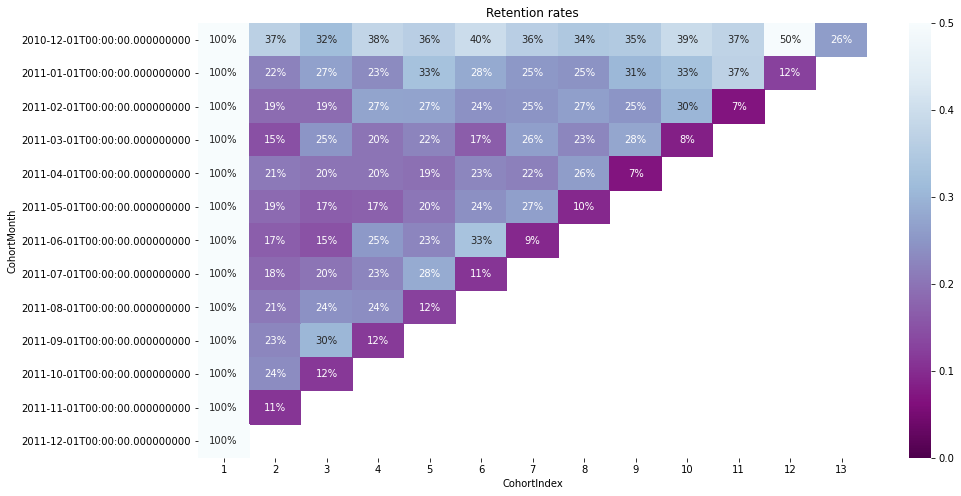

In [18]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()

Note That: Customer retention is a very useful metric to understand how many of the all customers are still active.Retention gives you the percentage of active customers compared to the total number of customers

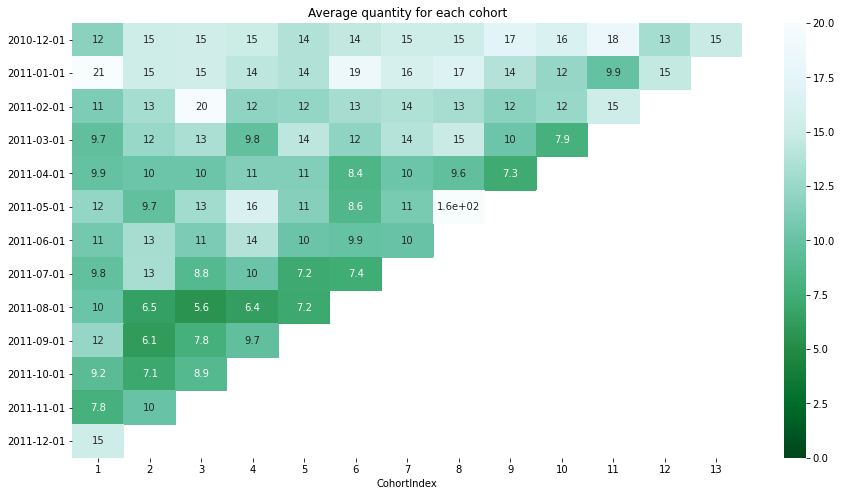

In [19]:
#Average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()

RFM Calculation

In [20]:
#New Total Sum Column  
df['TotalSum'] = df['UnitPrice']* df['Quantity']

#Data preparation steps
print('Min Invoice Date:',df.InvoiceDate.dt.date.min(),'max Invoice Date:',
       df.InvoiceDate.dt.date.max())

df.head(3)

Min Invoice Date: 2010-12-01 max Invoice Date: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
1,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,16126.0,United Kingdom,2011-06-01,2011-02-01,5,30.00
2,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,18118.0,United Kingdom,2011-05-01,2010-12-01,6,5.10
3,541658,21988,PACK OF 6 SKULL PAPER PLATES,1,2011-01-20 12:16:00,0.85,15529.0,United Kingdom,2011-01-01,2010-12-01,2,0.85


In [21]:
#In the real world, we would be working with the most recent snapshot of the data of today or yesterday
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date
#The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, 
#let's set one day after the last one,or 
#10 DEC as a snapshot_date. We will cound the diff days with snapshot_date.

Timestamp('2011-12-10 12:50:00')

In [22]:
# Calculate RFM metrics
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
                                      'InvoiceNo':'count','TotalSum': 'sum'})
#Function Lambdea: it gives the number of days between hypothetical today and the last transaction
#Rename columns
rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'MonetaryValue'}
           ,inplace= True)
#Final RFM values
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,132,3124.96
12348.0,75,20,1009.88
12349.0,19,50,1344.17
12350.0,310,11,213.30


In [23]:
#Building RFM segments
r_labels =range(4,0,-1)
f_labels=range(1,5)
m_labels=range(1,5)
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels = r_labels)
f_quartiles = pd.qcut(rfm['Frequency'],q=4, labels = f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'],q=4,labels = m_labels)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score
#def add_rfm(x) : return x['R'] + x['F'] + ['M']
#rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )
rfm['RFM_Segment'] = rfm["R"].astype(str)+rfm["F"].astype(str)+rfm["M"].astype(str)
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,132,3124.96,4,4,4,444,12
12348.0,75,20,1009.88,2,2,3,223,7
12349.0,19,50,1344.17,3,3,4,334,10
12350.0,310,11,213.30,1,1,2,112,4


Analyzing RFM Segments
Largest RFM segments It is always the best practice to investigate the size of the segments before you use them for targeting or other business Application.

In [24]:
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

RFM_Segment
444    448
111    388
344    207
211    184
122    182
dtype: int64

In [25]:
#Filtering on RFM segments

#Select bottom RFM segment "111" and view top 5 rows
rfm[rfm['RFM_Segment']=='111'].head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12353.0,204,3,71.30,1,1,1,111,3
12361.0,287,7,139.20,1,1,1,111,3
12401.0,303,3,58.35,1,1,1,111,3
12402.0,323,10,206.10,1,1,1,111,3
12441.0,367,8,123.15,1,1,1,111,3


In [26]:
#Summary metrics per RFM Score

rfm.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean',
                             'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           260.4       5.9         111.2   388
4           178.7       9.9         170.1   395
5           146.5      14.2         250.0   494
6           102.4      20.0         676.9   459
7            82.9      27.7         532.3   449
8            61.4      39.5         689.9   481
9            47.2      55.5        1430.5   403
10           32.4      79.1        1443.7   430
11           21.1     133.9        2904.0   373
12            7.3     258.9        6454.4   448

In [27]:
#Use RFM score to group customers into Gold, Silver and Bronze segments:

def segments(df):
    if df['RFM_Score'] > 9 :
        return 'Gold'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 9 ):
        return 'Sliver'
    else:  
        return 'Bronze'

rfm['General_Segment'] = rfm.apply(segments,axis=1)

rfm.groupby('General_Segment').agg({'Recency':'mean','Frequency':'mean',
                                    'MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            191.1      10.4         183.1  1277
Gold               20.0     159.9        3673.5  1251
Sliver             74.1      35.1         813.6  1792

In [28]:
#K Means Clustering
rfm_rfm = rfm[['Recency','Frequency','MonetaryValue']]
print(rfm_rfm.describe())

           Recency    Frequency  MonetaryValue
count  4320.000000  4320.000000    4320.000000
mean     93.019213    63.932870    1455.412403
std     100.373017   158.847859    6427.404543
min       1.000000     1.000000       1.900000
25%      18.000000    12.000000     210.082500
50%      51.000000    29.000000     479.460000
75%     144.000000    70.000000    1180.405000
max     374.000000  5413.000000  190759.920000


From this table, we find this Problem: Mean and Variance are not Equal

Soluation: Scaling variables by using a scaler from scikit-learn library

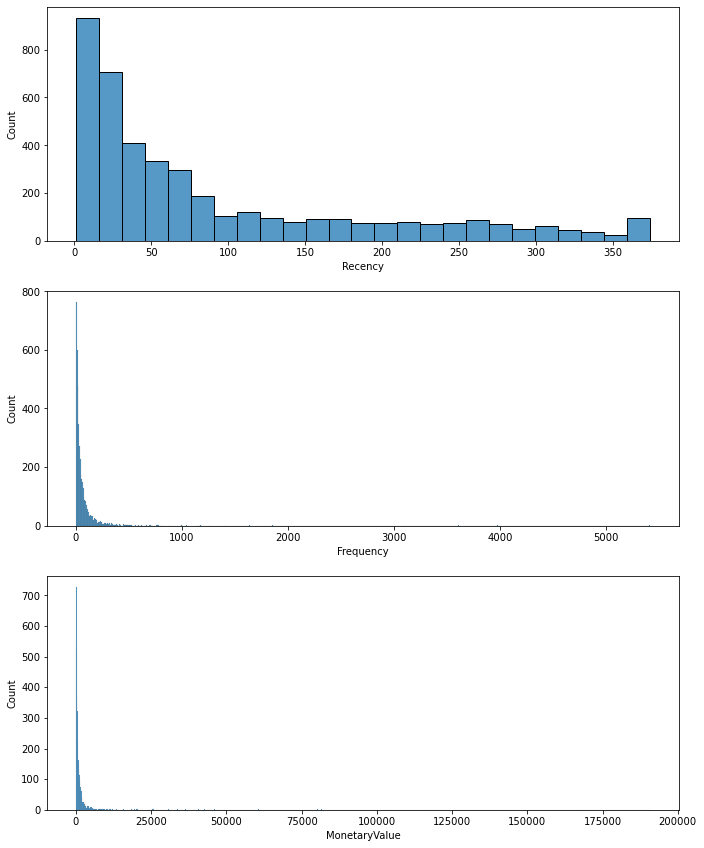

In [29]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.histplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.histplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.histplot(rfm.MonetaryValue, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

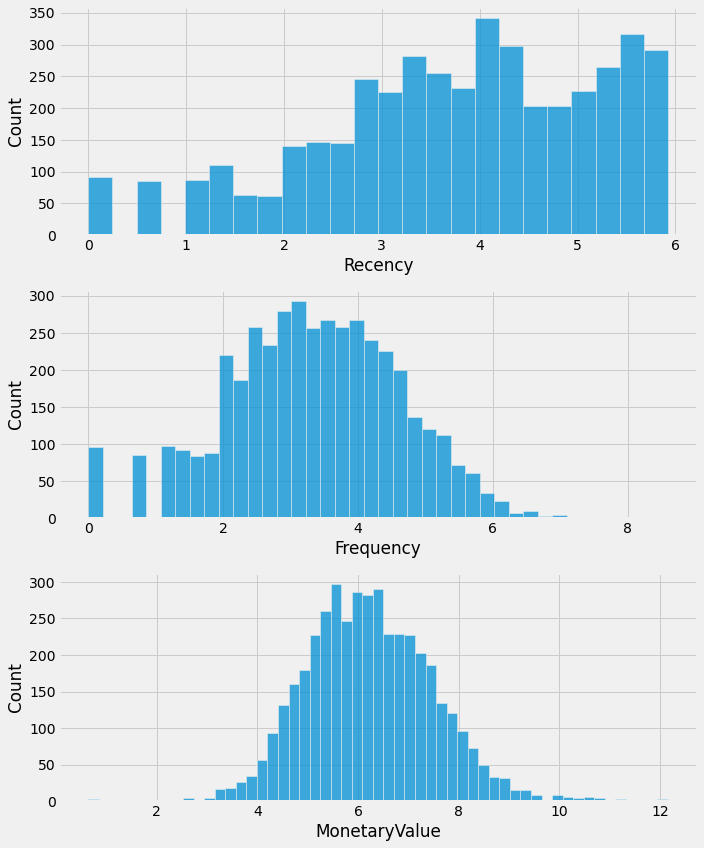

In [30]:
#Unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)
#or rfm_log = np.log(rfm_rfm)


# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.histplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.histplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.histplot(rfm_log.MonetaryValue, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [31]:
#Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
#Store it separately for clustering
rfm_normalized= scaler.transform(rfm_log)

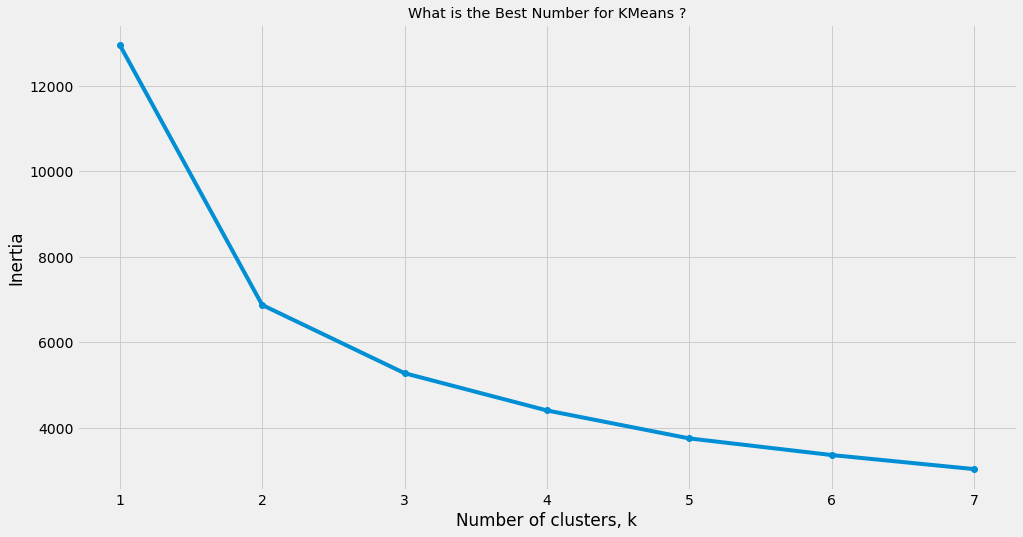

In [32]:
from sklearn.cluster import KMeans

#First : Get the Best KMeans 
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

In [33]:
# clustering
kc = KMeans(n_clusters= 3, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_rfm_k3 = rfm_rfm.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count'],}).round(0)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0           169.0      11.0         206.0  1557
1            69.0      48.0         881.0  1850
2            12.0     188.0        4749.0   913

In [34]:
# The further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm_rfm_k3.groupby(['K_Cluster']).mean()
population_avg = rfm_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
K_Cluster,,,
0,0.82,-0.83,-0.86
1,-0.26,-0.25,-0.39
2,-0.87,1.93,2.26


In [35]:
# the mean value in total 
total_avg = rfm.iloc[:, 0:3].mean()
# calculate the proportional gap with total mean
cluster_avg = rfm.groupby('General_Segment').mean().iloc[:, 0:3]
prop_rfm = cluster_avg/total_avg - 1
prop_rfm.round(2)

,Recency,Frequency,MonetaryValue
General_Segment,,,
Bronze,1.05,-0.84,-0.87
Gold,-0.78,1.50,1.52
Sliver,-0.20,-0.45,-0.44


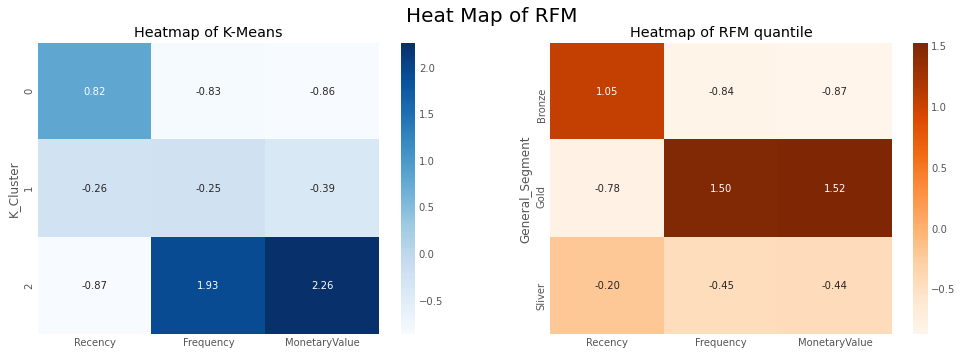

In [36]:
# heatmap with RFM
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")

# a snake plot with K-Means
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()

In [37]:
rfm.to_excel("rfm.xlsx")